In [1]:
import sys, os
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np

In [3]:
from core_enrich_ia_elts_cluster_discrete import lib as core
from snii_enrich_ia_elts_discrete import lib as snii_discrete
from snii_enrich_ia_elts_cluster import lib as snii_continuous

In [4]:
core.detailed_enrichment_init()
snii_discrete.detailed_enrichment_init()
snii_discrete.init_rand()
snii_continuous.detailed_enrichment_init()

In [21]:
from collections import defaultdict
import numpy as np
from tabulation import Lifetimes
from tabulation import IMF
from scipy import integrate
from tqdm import tqdm_notebook as tqdm

import betterplotlib as bpl
bpl.presentation_style()

In [6]:
sn_ii_idxs = {"C": 0, "N": 1, "O":2, "Mg":3, "S":4, "Ca": 5, "Fe": 6,
              "Z_II": 7, "Z": 7, "total": 8, "E": 9, "N_SN": 10, "N_SN_left": 11}

# Check rates

In [7]:
dt = 1E4
times = np.arange(1E6, 50E6, dt)

In [15]:
lt = Lifetimes("Raiteri_96")
imf = IMF("Kroupa", 0.08, 50)

In [9]:
m_test = 1E8

In [10]:
snii_discrete.get_ejecta_sn_ii_py(0, 55, 7, m_test, 0.02)[0]

324279.1848569

Have a range of metallicities, including some that are not in the grid.

In [11]:
zs = [0.004, 0.0075, 0.01, 0.015, 0.02]

In [12]:
turnoff_masses = {z: [lt.turnoff_mass(t, z) for t in tqdm(times)] for z in zs}

/Users/gillenb/miniconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Discrete')

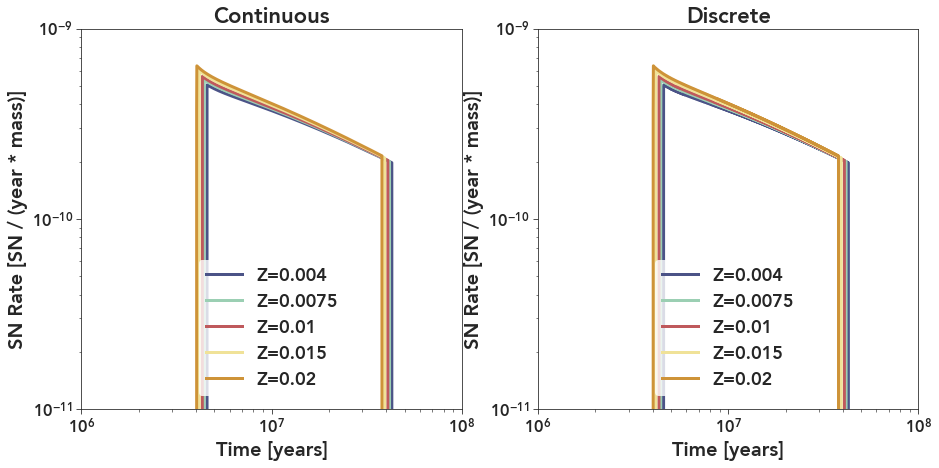

In [13]:
fig, axs = bpl.subplots(figsize=[15, 7], ncols=2)
for z in zs:
    ms = turnoff_masses[z]
    
    sn_rate_c = []
    sn_rate_d = []
    for idx in range(len(ms) - 1):
        m_now = ms[idx]
        m_next = ms[idx + 1]
        
        sn_rate_c.append(snii_continuous.get_ejecta_sn_ii_py(0, m_now, m_next, m_test, z)[sn_ii_idxs["N_SN"]] / (dt * m_test))
        sn_rate_d.append(snii_discrete.get_ejecta_sn_ii_py(0, m_now, m_next, m_test, z)[sn_ii_idxs["N_SN"]] / (dt * m_test))
    axs[0].plot(times[:-1], sn_rate_c, label="Z={}".format(z))
    axs[1].plot(times[:-1], sn_rate_d, label="Z={}".format(z))
for ax in axs:
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.add_labels("Time [years]", "SN Rate [SN / (year * mass)]")
    ax.legend()
    ax.set_limits(1E6, 1E8, 1E-11, 1E-9)
axs[0].set_title("Continuous")
axs[1].set_title("Discrete")

In [40]:
def analytic_sn_rate(time, z):

    logZ = np.log10(z)
    
    a0 = 10.13 + 0.07547*logZ - 0.008084*logZ*logZ
    a1 = -4.424 - 0.7939*logZ - 0.1187*logZ*logZ
    a2 = 1.262 + 0.3385*logZ + 0.05417*logZ*logZ
    
    sqrt_term = a1**2 - 4 * a2 * (a0 - np.log10(time))
    
    if sqrt_term < 0:
        return 0
    
    term = (a1 + np.sqrt(sqrt_term)) / (2 * a2)
    
    log_dn_dt = np.log10(imf.normalization) + 1.3 * term
    
    return 10**log_dn_dt / 1E9

In [71]:
def correct_analytic_sn_rate(time, z):

    logZ = np.log10(z)
    
    a0 = 10.13 + 0.07547*logZ - 0.008084*logZ*logZ
    a1 = -4.424 - 0.7939*logZ - 0.1187*logZ*logZ
    a2 = 1.262 + 0.3385*logZ + 0.05417*logZ*logZ
    
    def inside_derivative(t):
        
        sqrt_term = a1**2 - 4 * a2 * (a0 - np.log10(t))
    
        if sqrt_term < 0:
            return 0
    
        return 10**(1.3 * (a1 + np.sqrt(sqrt_term)) / (2 * a2))
    
    
    derivative = inside_derivative(time+1) - inside_derivative(time)
    
    return imf.normalization * derivative / 70

In [72]:
def fire_cumulative(time):
    t6 = time / 1E6
    
    if t6 < 3.4:
        return 0
    
    if t6 < 10.37:
        return (5.408 * t6 - 18.39) * 1E-4
    if t6 < 37.53:
        return (2.516 * t6 + 11.6) * 1E-4
    else:
        return 1.06E-2
    
def fire_rate(time):
    return fire_cumulative(time+1) - fire_cumulative(time)

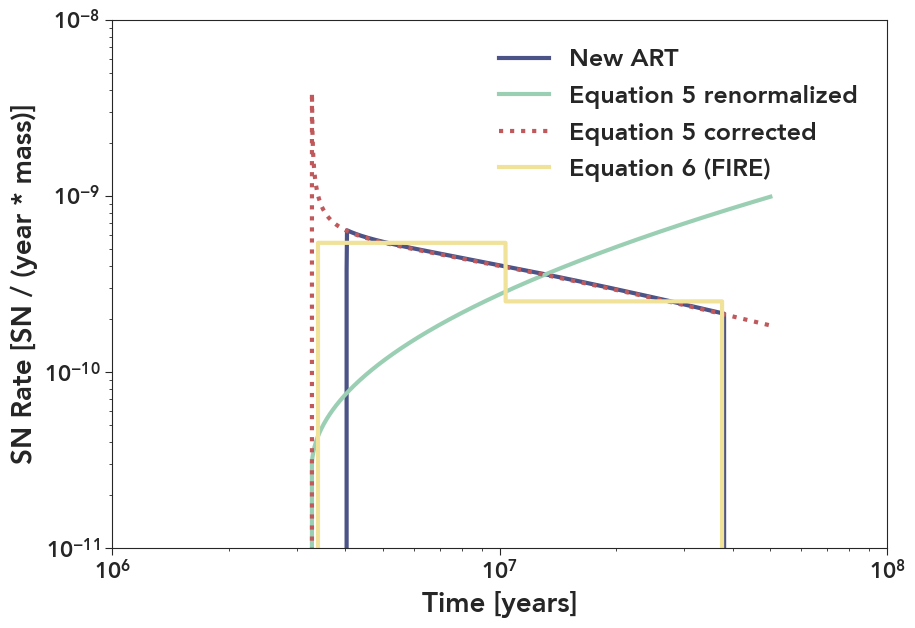

In [75]:
fig, ax = bpl.subplots()
z = 0.02
ms = turnoff_masses[z]

sn_rate_c = []
sn_rate_d = []
for idx in range(len(ms) - 1):
    m_now = ms[idx]
    m_next = ms[idx + 1]

    sn_rate_c.append(snii_continuous.get_ejecta_sn_ii_py(0, m_now, m_next, m_test, z)[sn_ii_idxs["N_SN"]] / (dt * m_test))
    
    
ax.plot(times[:-1], sn_rate_c, label="New ART")

ax.plot(times, [analytic_sn_rate(t, z) for t in times], label="Equation 5 renormalized")
ax.plot(times, [correct_analytic_sn_rate(t, z) for t in times], ls=":", label="Equation 5 corrected")
ax.plot(times, [fire_rate(t) for t in times], label="Equation 6 (FIRE)")

ax.set_xscale("log")
ax.set_yscale("log")
ax.add_labels("Time [years]", "SN Rate [SN / (year * mass)]")
ax.legend()
ax.set_limits(1E6, 1E8, 1E-11, 1E-8)